In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_xgb_feature_importance


In [4]:
sheet = pd.read_excel('data_input/沪铝期货价格.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['沪铝期货价格'].last_valid_index()
# 获取last_day之后的数据
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]


sheet.columns
sheet

,沪铝期货价格,铝现货进口升贴水,LME铜价,沪铝月差/连1-连3,铝社会库存（锭+棒）(处理预测短期)超季节性/3年,LME铝升贴水/0-3/5DMA
1995-04-17,19500.0,NaN,NaN,NaN,NaN,NaN
1995-04-18,19500.0,NaN,NaN,NaN,NaN,NaN
1995-04-19,19460.0,NaN,NaN,NaN,NaN,NaN
1995-04-20,19180.0,NaN,NaN,NaN,NaN,NaN
1995-04-21,18850.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2025-06-23,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-24,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-25,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-26,NaN,NaN,NaN,NaN,-8.488,NaN


In [5]:
fill_methods = {
    '铝现货进口升贴水': 'interpolate',
      'LME铜价': 'interpolate', 
      '沪铝月差/连1-连3': 'interpolate',
       '铝社会库存（锭+棒）(处理预测短期)超季节性/3年': 'interpolate', 
       'LME铝升贴水/0-3/5DMA': 'interpolate'   
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '沪铝期货价格'] = sheet.loc[:last_day, '沪铝期货价格'].interpolate(method='linear')

sheet['铝现货进口升贴水_提前20天'] = sheet['铝现货进口升贴水'].shift(20)        
sheet['沪铝月差/连1-连3_提前45天'] = sheet['沪铝月差/连1-连3'].shift(45)
sheet['LME铝升贴水/0-3/5DMA_提前20天'] = sheet['LME铝升贴水/0-3/5DMA'].shift(20)


sheet['沪铝月差/连1-连3_提前45天_逆序'] = reverse_column(sheet, '沪铝月差/连1-连3_提前45天')
sheet['铝社会库存（锭+棒）(处理预测短期)超季节性/3年_逆序'] = reverse_column(sheet, '铝社会库存（锭+棒）(处理预测短期)超季节性/3年')                                   


################################# 数据筛选  #################################
# 重置索引 确保 `Date` 为 datetime 类型
sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
# 筛选日期大于 2024-01-01 的行
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-01-01')]
# 重置索引,使其从0开始 
sheet_daily = sheet_daily.reset_index(drop=True)
# 删除 在 last_day 之前 预测标的 为 空值的 行
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['沪铝期货价格'].notna())                                   
]


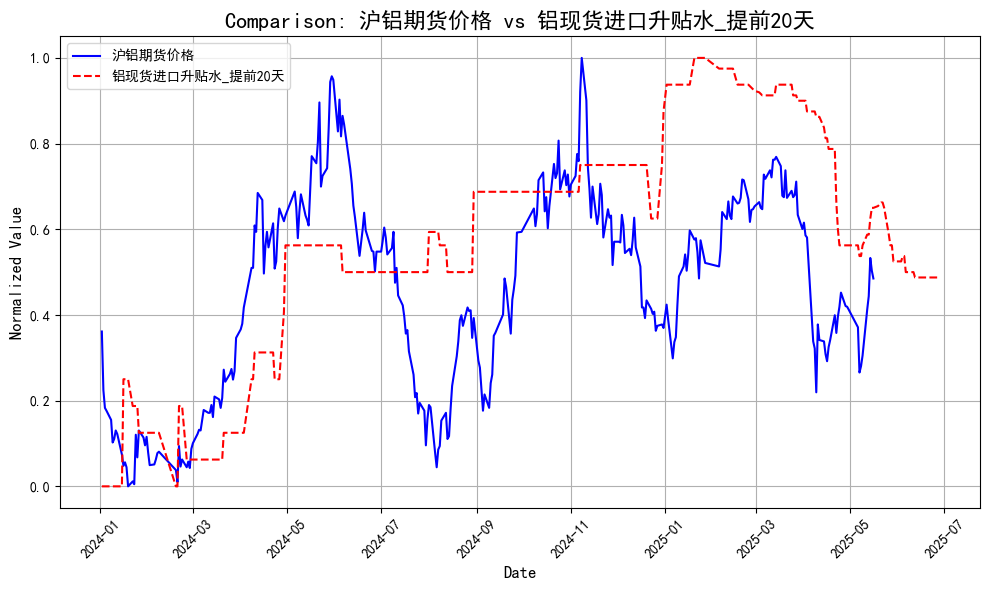

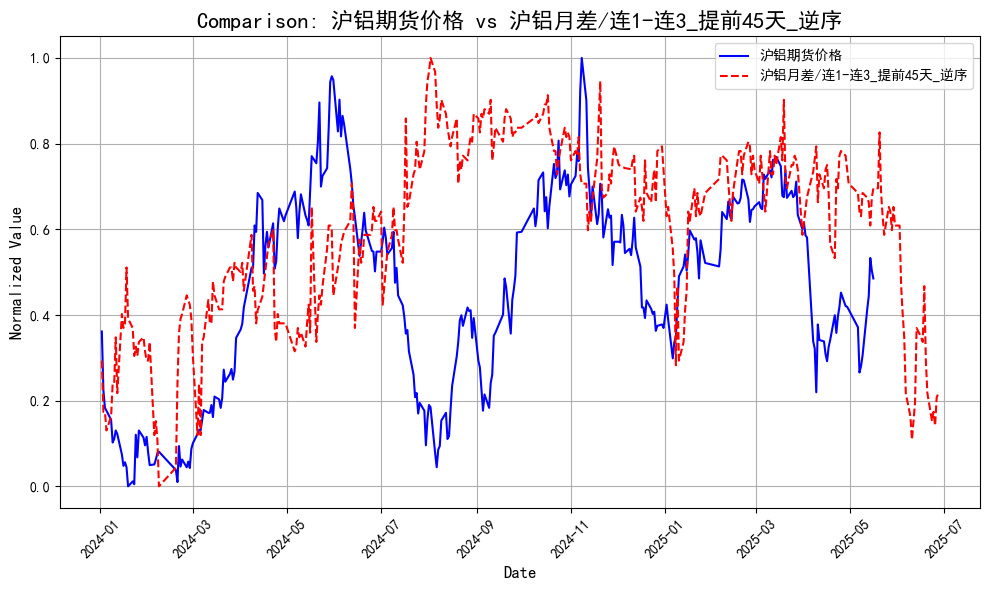

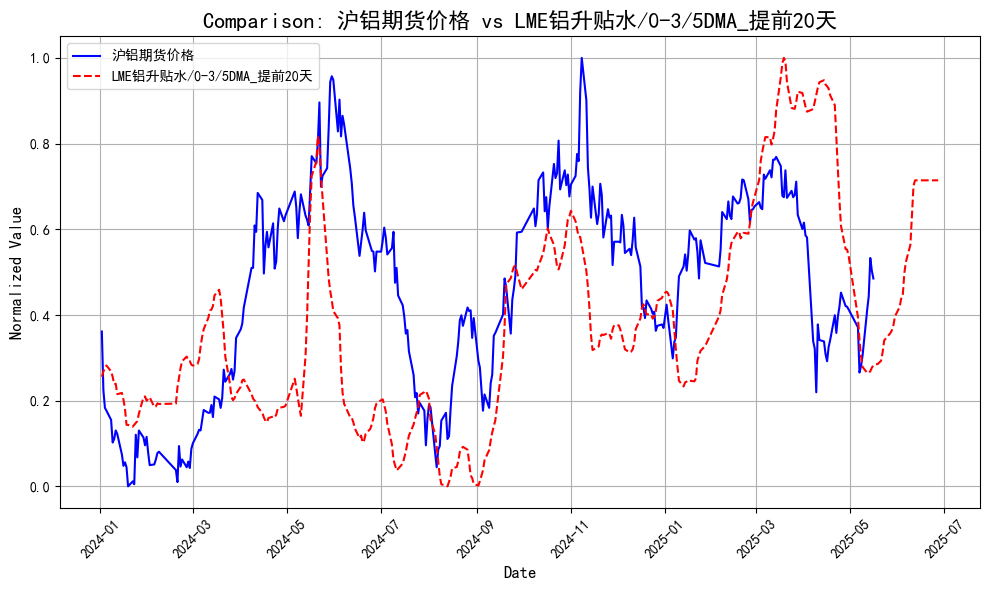

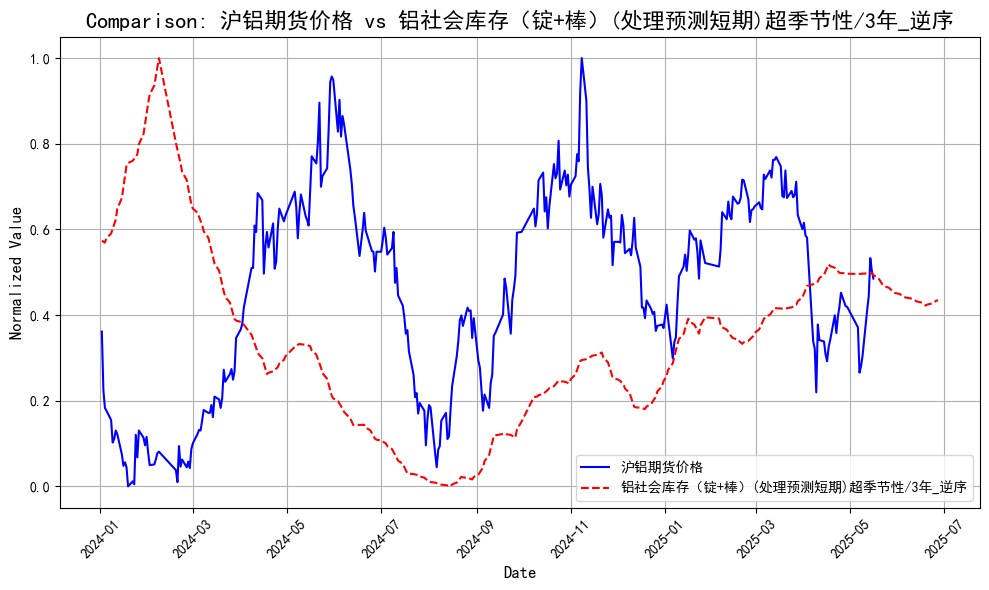

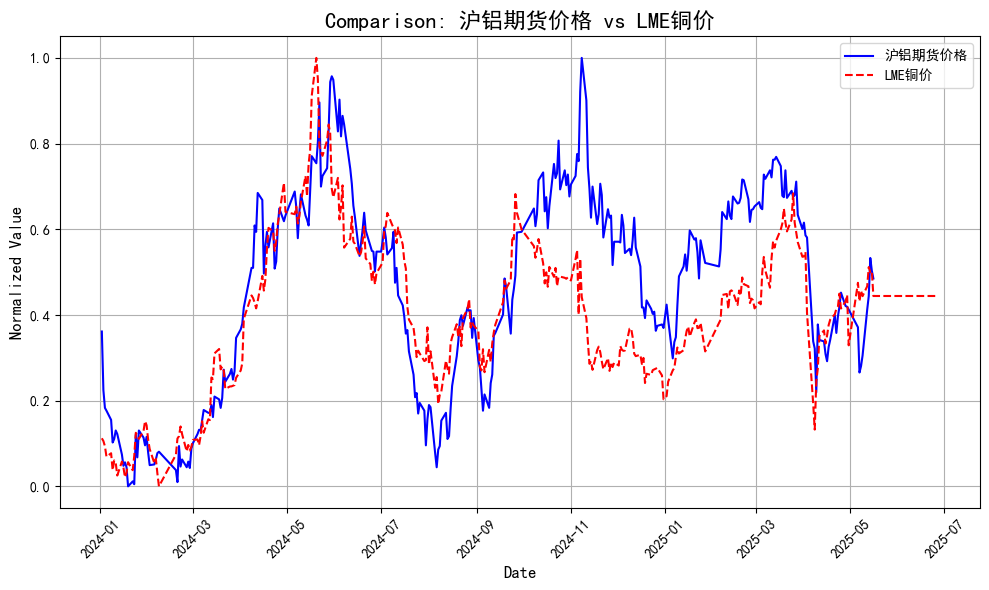

In [6]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='沪铝期货价格',   
    compare_cols=[
        '铝现货进口升贴水_提前20天', 
        '沪铝月差/连1-连3_提前45天_逆序', 
        'LME铝升贴水/0-3/5DMA_提前20天',
        '铝社会库存（锭+棒）(处理预测短期)超季节性/3年_逆序', 
        'LME铜价',          

        ]
)


In [26]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 30
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '铝现货进口升贴水_提前20天', 
        '沪铝月差/连1-连3_提前45天_逆序', 
        'LME铝升贴水/0-3/5DMA_提前20天',
        '铝社会库存（锭+棒）(处理预测短期)超季节性/3年_逆序', 
        'LME铜价'          
]

predict_column = '沪铝期货价格'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# GBLinear 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 设置GBLinear参数
params = {
    'booster': 'gblinear',  # 使用线性提升器
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.1,  # 学习率
    'lambda': 0,  # L2正则化
    'alpha': 0,  # L1正则化
    'updater': 'coord_descent',  # 坐标下降优化
    'feature_selector': 'thrifty',  # 特征选择方法
    'eval_metric': 'rmse',  # 评估指标
    'seed': 42,  # 随机种子
}

num_boost_round = 1000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix,
    num_boost_round,
    evals=[(test_dmatrix, 'eval'), (train_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=100
)

y_train_pred = model.predict(train_dmatrix)
y_test_pred = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"训练集 MSE: {round(train_mse, 4)}, 训练集 R²: {round(train_r2, 4)}")
print(f"测试集 MSE: {round(test_mse, 4)}, 测试集 R²: {round(test_r2, 4)}")

##### 预测未来数据和结果存储 #####
y_future_pred = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred

[0]	eval-rmse:396.53143	train-rmse:634.14839


[100]	eval-rmse:577.48826	train-rmse:357.33597
[200]	eval-rmse:573.96325	train-rmse:357.07681
[300]	eval-rmse:573.91272	train-rmse:357.04346
[400]	eval-rmse:573.90415	train-rmse:357.03840
[500]	eval-rmse:573.90957	train-rmse:357.03749
[600]	eval-rmse:573.91042	train-rmse:357.03737
[606]	eval-rmse:573.91044	train-rmse:357.03745
训练集 MSE: 127475.7425, 训练集 R²: 0.7614
测试集 MSE: 329373.1916, 测试集 R²: -2.8722


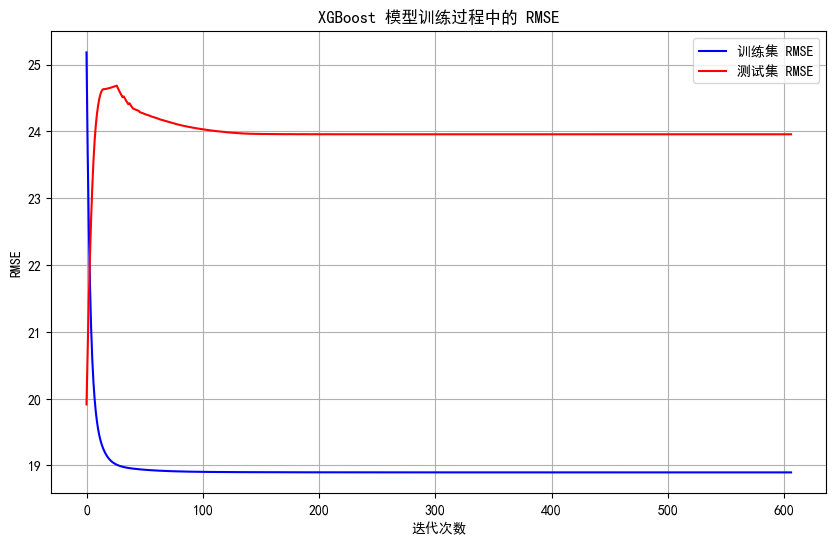

In [27]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)




# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=100
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:622.34291
[100]	train-rmse:371.57603
[200]	train-rmse:371.42097
[300]	train-rmse:371.41291
[400]	train-rmse:371.41219
[500]	train-rmse:371.41221
[531]	train-rmse:371.41221
全部数据 MSE: 137946.9816, 全部数据 R²: 0.7226


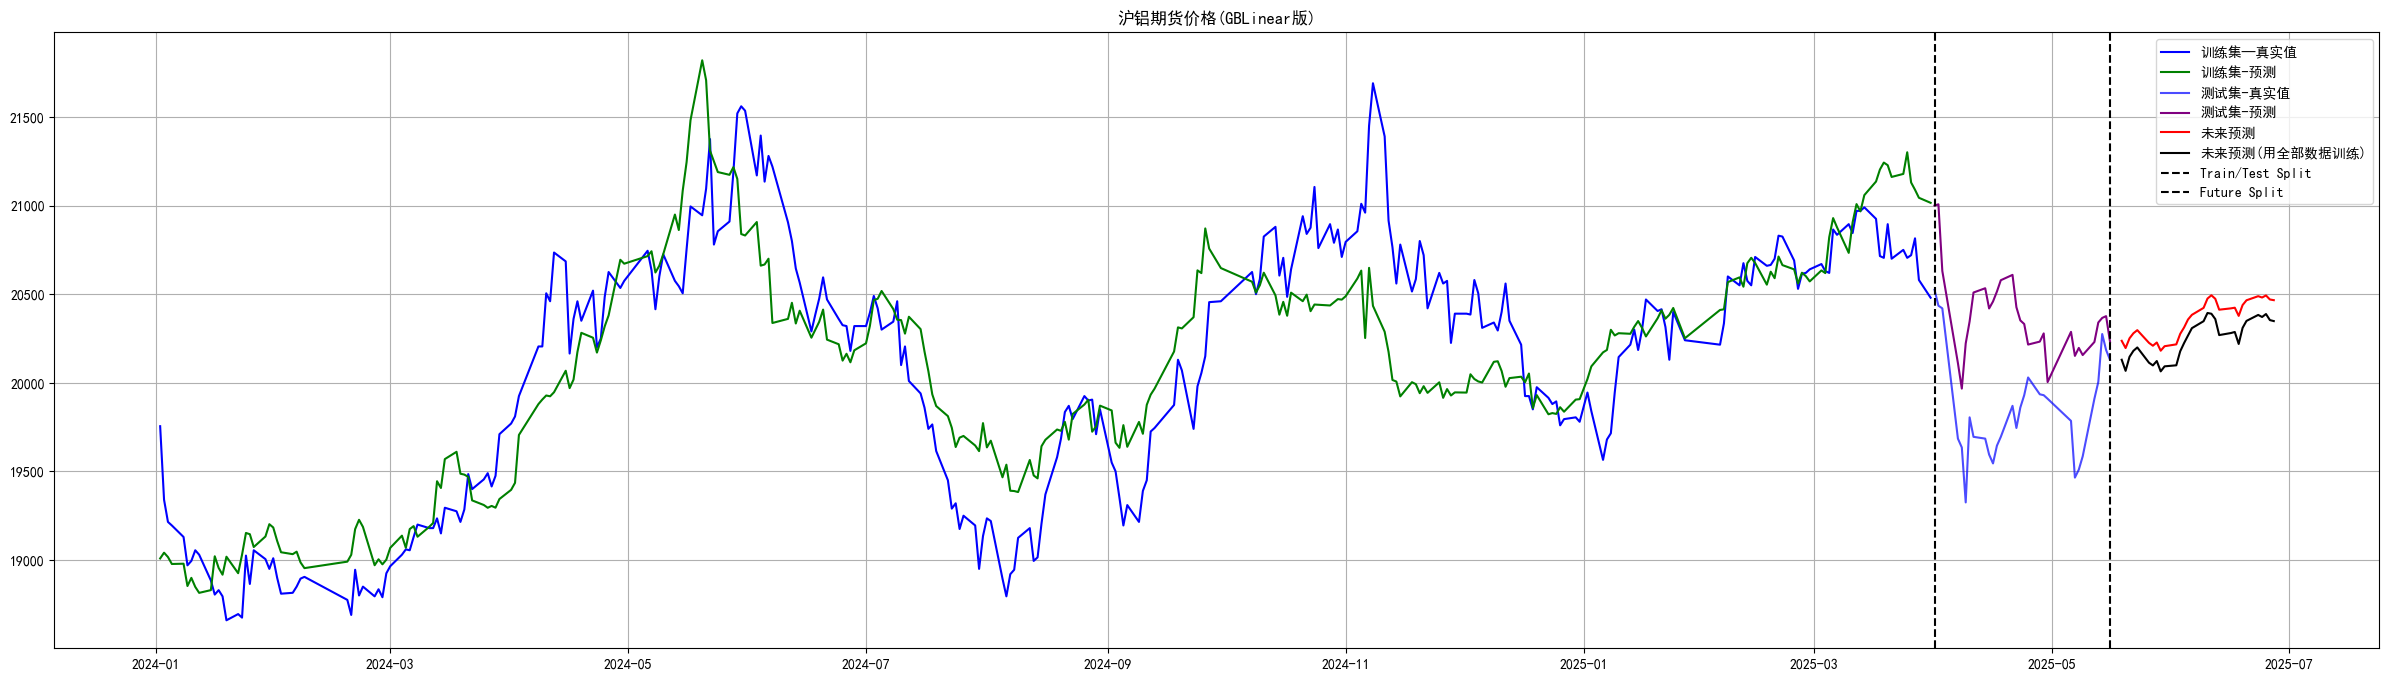

In [33]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
#future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')


# 设置标题和图例
plt.title('沪铝期货价格(GBLinear版)')   
plt.legend()
plt.grid(True)
plt.show()


---

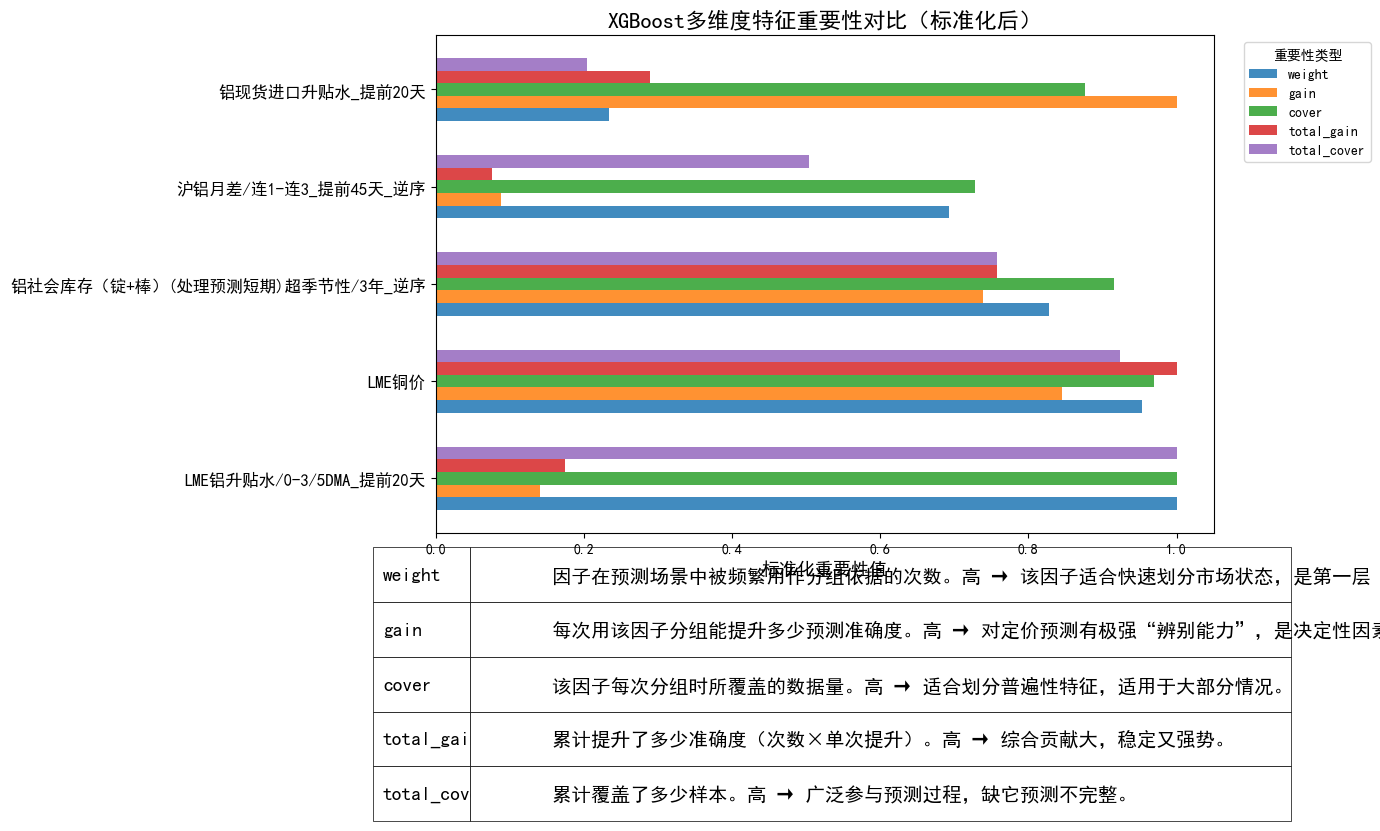

,weight,gain,cover,total_gain,total_cover
LME铝升贴水/0-3/5DMA_提前20天,1.000000,0.141041,1.000000,0.174973,1.000000
LME铜价,0.952891,0.845920,0.969284,1.000000,0.923623
铝社会库存（锭+棒）(处理预测短期)超季节性/3年_逆序,0.827767,0.738206,0.915520,0.758076,0.757837
沪铝月差/连1-连3_提前45天_逆序,0.692672,0.088221,0.727845,0.075810,0.504158
铝现货进口升贴水_提前20天,0.233549,1.000000,0.875738,0.289738,0.204528


In [11]:
#绘制因子重要性
plot_xgb_feature_importance(model_all, X_train)


In [12]:
################################# 训练预测数据 excel格式输出  #################################

############ 日度 数据 ############
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})

historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})

merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/铁矿期货价格拟合残差_合并数据.xlsx', index=False,float_format='%.4f')         

############ 月度 数据 ############
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
test_pred_2024 = test_data[['Date', '预测值']].copy()
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 将真实值和预测值控制在5位有效数
merged_df_monthly['真实值'] = merged_df_monthly['真实值'].apply(lambda x: float(f'%.5g' % x))
merged_df_monthly['预测值'] = merged_df_monthly['预测值'].apply(lambda x: float(f'%.5g' % x))

merged_df_monthly.to_excel('eta/沪铝期货价格_月度数据.xlsx', index=False,float_format= '%.4f')       

In [13]:
merged_df_monthly

,Date,真实值,预测值
17,2025/06/30,NaN,20289.0
16,2025/05/31,19872.0,20271.0
15,2025/04/30,19852.0,20160.0
14,2025/03/31,20775.0,20775.0
13,2025/02/28,20610.0,20610.0
12,2025/01/31,20123.0,20123.0
11,2024/12/31,20129.0,20129.0
10,2024/11/30,20790.0,20789.0
9,2024/10/31,20757.0,20757.0
8,2024/09/30,19755.0,19755.0


In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.铝_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "沪铝期货价格"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
file_path = "eta/1.铝_数据上传.xlsx"
sheet_name = "详情页"
identifier = "沪铝期货价格"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/05/31)
数据已成功更新到Excel文件
